# Пайплайн

1. Считать все матрицы в `train` и `test` выборки
2. Обучить нейросеть

# Библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

plt.rcParams.update({'font.size': 14})

In [2]:
import os

In [3]:
MSIZE = 256

In [4]:
MATRIX_DIR = "matrices"
MUSIC_DIR = "music"
PICS_DIR = "pics"

MUSIC_MATRIX_FULL_DIR = os.path.join(MATRIX_DIR, MUSIC_DIR)
PICS_MATRIX_FULL_DIR = os.path.join(MATRIX_DIR, PICS_DIR)

MUSIC_MATRICIES = list(map(
    lambda x: os.path.join(MUSIC_MATRIX_FULL_DIR, x),
    os.listdir(MUSIC_MATRIX_FULL_DIR)
))
PICS_MATRICIES = list(map(
    lambda x: os.path.join(PICS_MATRIX_FULL_DIR, x),
    os.listdir(PICS_MATRIX_FULL_DIR)
))

MUSIC_MATRICIES[0]
PICS_MATRICIES[0]

N_MUSIC = len(MUSIC_MATRICIES)
N_PICS  = len(PICS_MATRICIES)


In [5]:
matricies = [
    np.zeros((N_MUSIC, MSIZE, MSIZE)),
    np.zeros((N_PICS, MSIZE, MSIZE)),
]

for mat in matricies:
    print(mat.shape)

(870, 256, 256)
(761, 256, 256)


In [6]:
# %%timeit -r 5 -n 5 
for i, mat in tqdm(enumerate(MUSIC_MATRICIES)):
    matricies[0][i] = np.fromfile(mat, dtype=np.uint32).reshape((MSIZE, MSIZE))
    
for i, mat in tqdm(enumerate(PICS_MATRICIES)):
    matricies[1][i] = np.fromfile(mat, dtype=np.uint32).reshape((MSIZE, MSIZE))

870it [00:00, 933.12it/s] 
761it [00:00, 1551.75it/s]


# Предваритальная обработка

In [7]:
S = 7.0
SIGMA = (S, S)

In [8]:
def smooth(mat):
    return gaussian_filter(mat, SIGMA, mode='constant', cval=mat.mean())

In [9]:
Ns = [
    N_MUSIC,
    N_PICS,
]

N_sample = min(Ns)

data_mats = np.zeros((len(Ns), N_sample, MSIZE, MSIZE))
data_mats.shape

(2, 761, 256, 256)

In [10]:
# %%timeit -n 5 -r 5
# matricies = np.array(list(map(smooth, matricies)))
for i in range(data_mats.shape[0]):
    for j in tqdm(range(data_mats.shape[1])):
        data_mats[i,j] = smooth(matricies[i][j])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 761/761 [00:03<00:00, 219.95it/s]


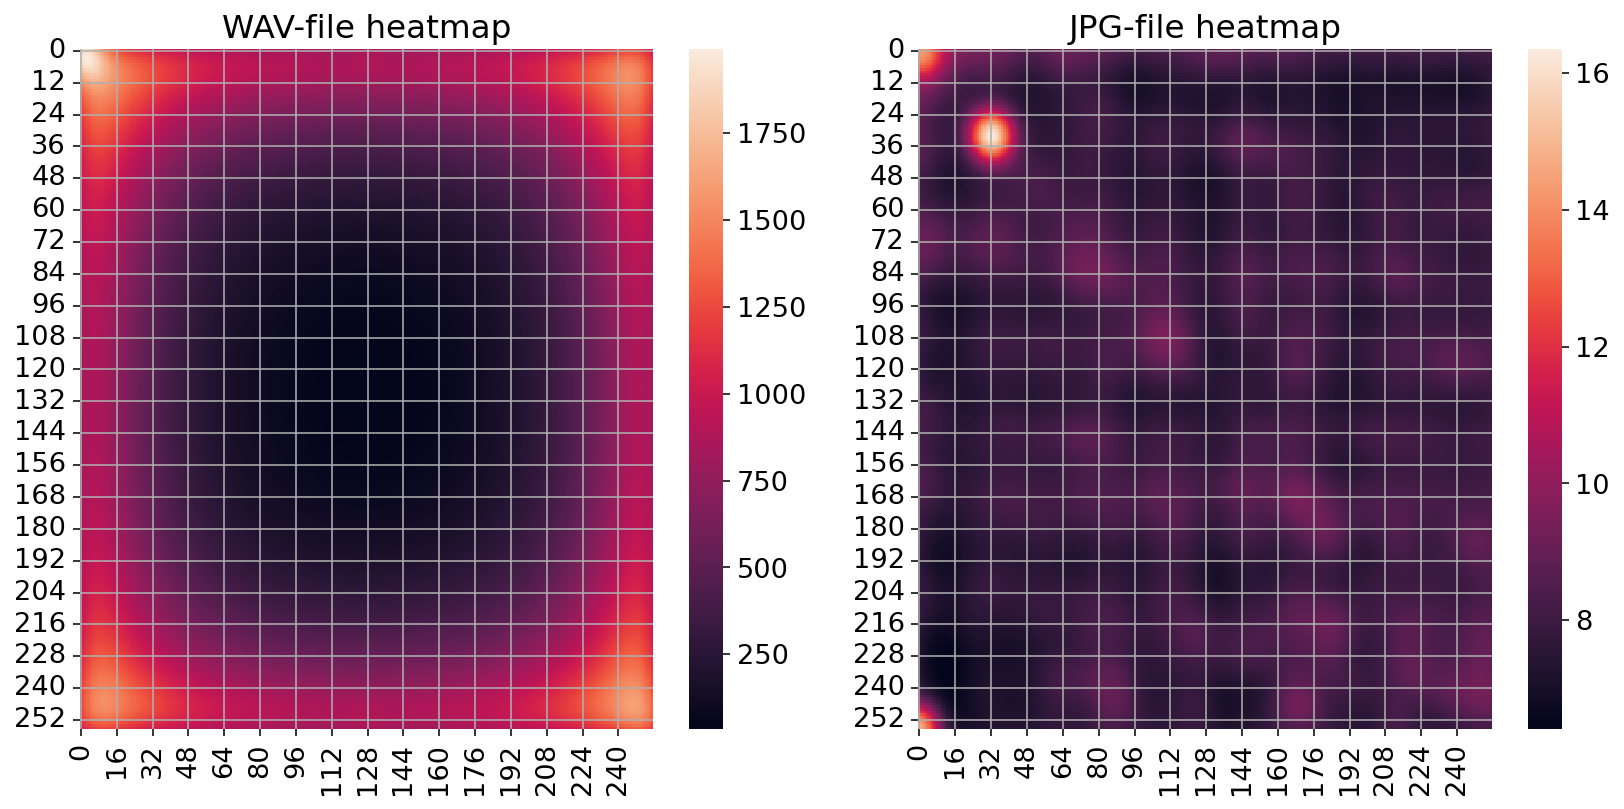

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), dpi=140)
# ax[0].grid()
# ax.set_xlim(1, 70)
# ax.set(xlabel='common xlabel', ylabel='common ylabel')

titles = [
    "WAV-file heatmap",
    "JPG-file heatmap",
]

for i, n in enumerate([N_MUSIC, N_PICS]):
    ax[i].grid()
    ax[i].set(
        title=titles[i],
    )
    sns.heatmap(data=data_mats[i].mean(axis=0), ax=ax[i])

plt.tight_layout()

# Обучение нейросети

## Подготовка выборок

In [12]:
labels = np.zeros((len(Ns), data_mats.shape[1]), dtype=np.uint8)

for i in range(len(Ns)):
    # WAV - 0
    # JPG - 1
    labels[i] = i
    
labels = labels.flatten()

In [13]:
train_coef = 0.7
train_size = int(N_sample * train_coef)
# test_size  = N_sample - train_size

In [14]:
data = np.zeros((len(Ns) * N_sample, MSIZE, MSIZE))

for i in range(data_mats.shape[0]):
    for j in range(N_sample):
        data[i*N_sample + j] = data_mats[i,j].copy()

In [15]:
indicies = np.random.choice(
    a=data.shape[0], 
    size=data.shape[0],
    replace=False
)
train_idx = indicies[:len(Ns)*train_size]
test_idx = indicies[len(Ns)*train_size:]

In [70]:
train_data = data[train_idx].reshape((1064, MSIZE**2))
test_data = data[test_idx].reshape((458, MSIZE**2))

train_labels = labels[train_idx]
test_labels = labels[test_idx]

print("train data shape:", train_data.shape)
print("test data shape:", test_data.shape)

train data shape: (1064, 65536)
test data shape: (458, 65536)


## Формирование нейросети

In [71]:
import torch
from torch import nn

In [72]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [73]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(MSIZE**2, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=65536, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [74]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [75]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [76]:
def train(data, model, loss_fn, optimizer, batch_size = 64):
    X_train = data[0]
    y_train = data[1]
    assert X_train.shape[0] == y_train.shape[0]
    model.train()
    idx = np.arange(X_train.shape[0])
    
    for i, batch_idx in enumerate(batch(idx, batch_size)):
        X = X_train[batch_idx] 
        y = y_train[batch_idx] 
        print(type(X), X.shape)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if i % 10 == 0:
            loss, current = loss.item(), (i+1)*len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [77]:
def test(data, model, loss_fn, batch_size = 64):
    X_test, y_test = data
    num_batches = X_test.shape[0] // batch_size + 1
    model.eval()
    test_loss, correct = 0, 0
    idx = np.arange(X_test.shape[0])
    with torch.no_grad():
        for i, batch_idx in batch(idx, batch_size):
            X = X_train[batch_idx]
            y = y_train[batch_idx]
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == 1).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= X_test.shape()
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [78]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train((train_data, train_labels), model, loss_fn, optimizer)
#     test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
<class 'numpy.ndarray'> (64, 65536)


TypeError: flatten() takes from 0 to 1 positional arguments but 2 were given

# Test

In [31]:
from enum import Enum
class filetype(Enum):
    WAV = 0
    JPG = 1
    
test = filetype.WAV
print(test )
(filetype.__dir__)

filetype.WAV


<function enum.Enum.__dir__(self)>

In [ ]:
from collections import bat